**Assignment 2 - Classification based on 2D features**

Approach:



*   Extract the 2-dimensional feature
*   Force the feature to have fixed size
*   Unroll the 2-dimensional feature into a 1-dimensional vector








In [22]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav
import librosa

import matplotlib.pyplot as plt
import IPython.display as ipd # Notebook only

# Classification tools
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# File management
from google.colab import drive
import tarfile
from shutil import copyfile

# Frequency analysis
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.signal import spectrogram
from librosa.feature import melspectrogram, mfcc
from librosa.display import specshow

In [23]:
# Link Google Drive account, transfer dataset, and extract files
drive.mount('/content/gdrive')
copyfile('/content/gdrive/MyDrive/Digital signal and image management/recordings.tar', 'recordings.tar')
tar = tarfile.open('recordings.tar')
tar.extractall()
tar.close()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Spectogram extraction

In [24]:
# Placecholder for feature extractor
def identity(input):
    return input


# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Classes
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test


In [25]:
def feats_spectrogram(input, rate=8000, tsize=10):

    frequencies, times, Sxx = spectrogram(input, fs=rate, nperseg=256, noverlap=128)

    # Normalizzation
    if Sxx.shape[1] > tsize:
        Sxx = Sxx[:, :tsize]
    elif Sxx.shape[1] < tsize:
        padding = np.zeros((Sxx.shape[0], tsize - Sxx.shape[1]))
        Sxx = np.concatenate((Sxx, padding), axis=1)  # Padding

    # 1D
    output = Sxx.flatten()
    return output

In [26]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_spectrogram, normalize=True)

X_train[0].shape

(1290,)

In [27]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 45.909s


In [28]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 1000
 gamma: 0.005


In [29]:
# SVM test
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.71      0.80        17
           1       0.67      1.00      0.80        10
           2       0.80      0.53      0.64        15
           3       0.65      0.58      0.61        19
           4       0.56      0.45      0.50        11
           5       1.00      0.71      0.83        14
           6       0.24      0.79      0.37        14
           7       0.55      0.32      0.40        19
           8       0.62      0.29      0.40        17
           9       0.64      0.50      0.56        14

    accuracy                           0.57       150
   macro avg       0.66      0.59      0.59       150
weighted avg       0.67      0.57      0.58       150



In [30]:
def feats_mfcc(input, rate=8000, tsize=10, n_mfcc=20):
    #  MFCC  20 coefficientis
    mfccs = librosa.feature.mfcc(y=input.astype(float), sr=rate, n_mfcc=n_mfcc, hop_length=512)

    # Normalizzation
    if mfccs.shape[1] > tsize:
        mfccs = mfccs[:, :tsize] `
    elif mfccs.shape[1] < tsize:
        padding = np.zeros((mfccs.shape[0], tsize - mfccs.shape[1]))
        mfccs = np.concatenate((mfccs, padding), axis=1)  # Padding se ci sono meno colonne

    #1D
    output = mfccs.flatten()
    return output


In [31]:

X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_mfcc, normalize=True)

print(X_train[0].shape)


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2033
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1963
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2007
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1976
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1987
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1886
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py

(200,)


Training completed in 11.396s
Best parameters combination:
 C: 100
 gamma: 0.005
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        14
           7       1.00      0.95      0.97        19
           8       1.00      1.00      1.00        17
           9       0.93      1.00      0.97        14

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

Confusion matrix:


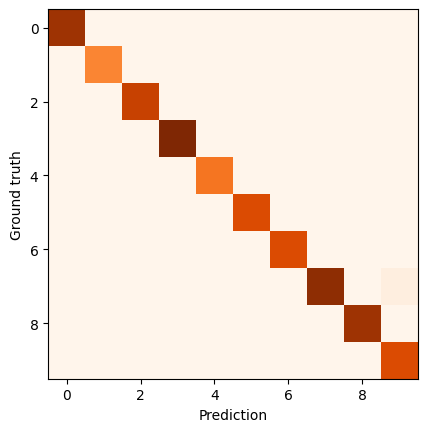

In [35]:

#cross-validation
param_grid = {'C': [100, 500, 1000],
              'gamma': [0.005, 0.01, 0.1, 0.5, 1.0]}

# SVM
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

#training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

print('Best parameters combination:')
print(' C: ' + str(clf.best_estimator_.C))
print(' gamma: ' + str(clf.best_estimator_.gamma))


y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

#Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Oranges)
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.show()

